# Regresión lineal: predecir los gastos médicos de pacientes
---

Para este ejercicio utilizaremos los datos presentados en [este](https://www.kaggle.com/mirichoi0218/insurance) dataset de Kaggle en el cual se presentan datos de seguros médicos. 


## Descarga e instalación de librerías

Lo primero que se hará es descargar la librería **[regressors](https://pypi.org/project/regressors/)** que ayudará a hacer un análisis más profundo sobre la regresión lineal.

In [92]:
#instalaciones
!pip install --upgrade pip setuptools==57.5.0
!pip install regressors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
#imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [94]:
#estilos sns
sns.set(style='whitegrid', context='notebook')

## Descargando los datos
Descarguemos los datos y veamos cómo se ven.

In [95]:
path = './insurance.csv'

df = pd.read_csv(path)

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Separando variables categóricas y numéricas

In [96]:
cols_numericas = [colname for colname in df.columns if df[colname].dtype in ['int64', 'float64']]

cols_categoricas = [colname for colname in df.columns if df[colname].dtype in ['object']]

## Analizando los datos
Se observará cómo se distribuyen los datos de la variable a predecir.

(1338, 7)


<Axes: >

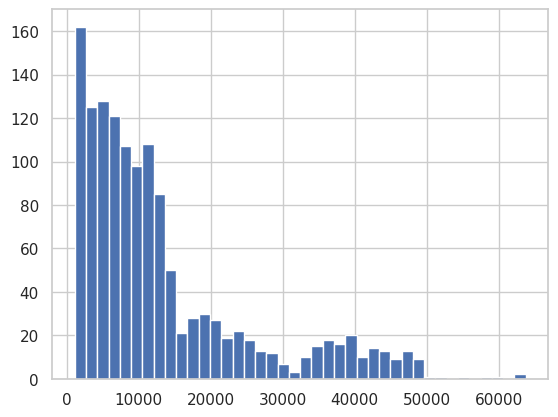

In [97]:
#dimension, instancias y features
print(df.shape)

#histograma de; target, bins # de barras
df.charges.hist(bins=40)

#entre 0-10k la mayoría, luego partes que nose ajustan tanto

Algo que analizar, según este gráfico, es entender qué está pasando con los datos arriba de los 50,000. Parece haber muy pocos datos de este lado.

In [98]:
df[df.charges>50000]

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,yes,southwest,51194.55914
543,54,female,47.410,0,yes,southeast,63770.42801
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
1230,52,male,34.485,3,yes,northwest,60021.39897
1300,45,male,30.360,0,yes,southeast,62592.87309


In [99]:
#hay muy pocos datos, tal vez se puedan borrar, preguntar a experto o diagrama de bigote en la realidad
df = df[df.charges<50000]
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


En este caso, al ser pocos datos (6 de 1338), eliminaremos estos datos atípicos. A modo didáctico producen más ruido en la predicción que se está intentando hacer en este ejercicio. 

Sin embargo es importante aclarar que **NO SE DEBEN ELIMINAR** datos atípicos sin antes conocer a alguien que conozca o sea experto en los datos para que pueda guiarnos mejor sobre ellos.

Joinplots interesantes, cargos vs edad, agrupados por smokers cargos vs fumadores

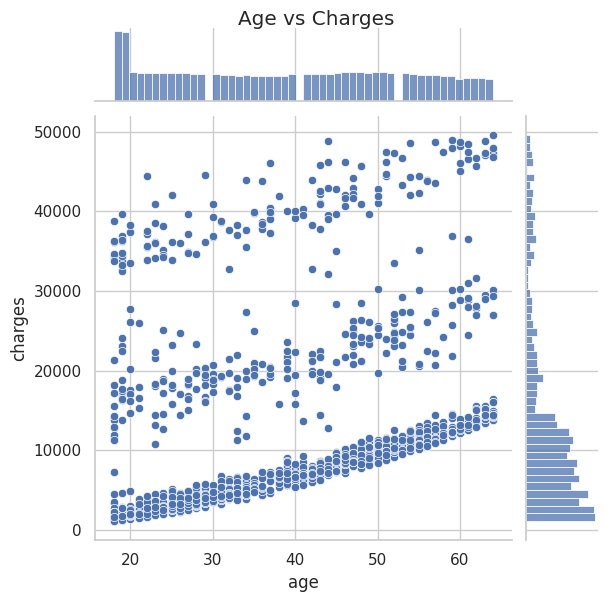

In [100]:
a = sns.jointplot(data= df, x=df.age, y=df.charges, marginal_kws={'bins':50})
a.fig.suptitle('Age vs Charges',y = 1.0)
plt.show()

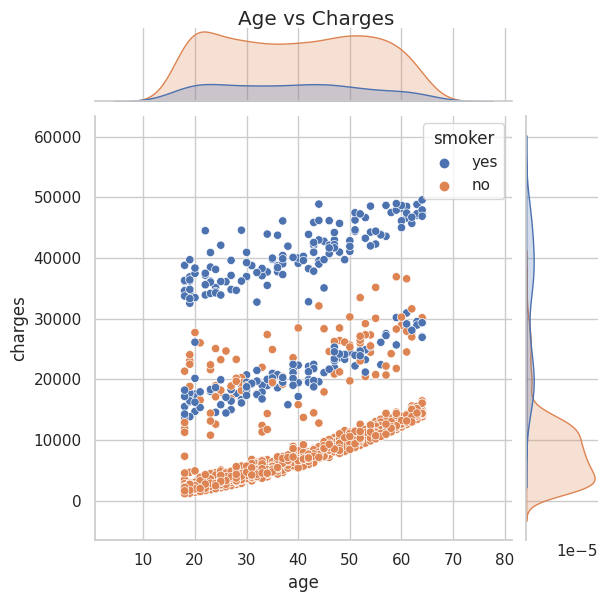

In [101]:
p = sns.jointplot(data = df, x = 'age', y = 'charges', hue = 'smoker')
p.fig.suptitle('Age vs Charges',y = 1.0)
plt.show()

## Viendo correlaciones
Ahora entendamos nuestros datos, viendo cómo se distribuyen y correlacionan. 

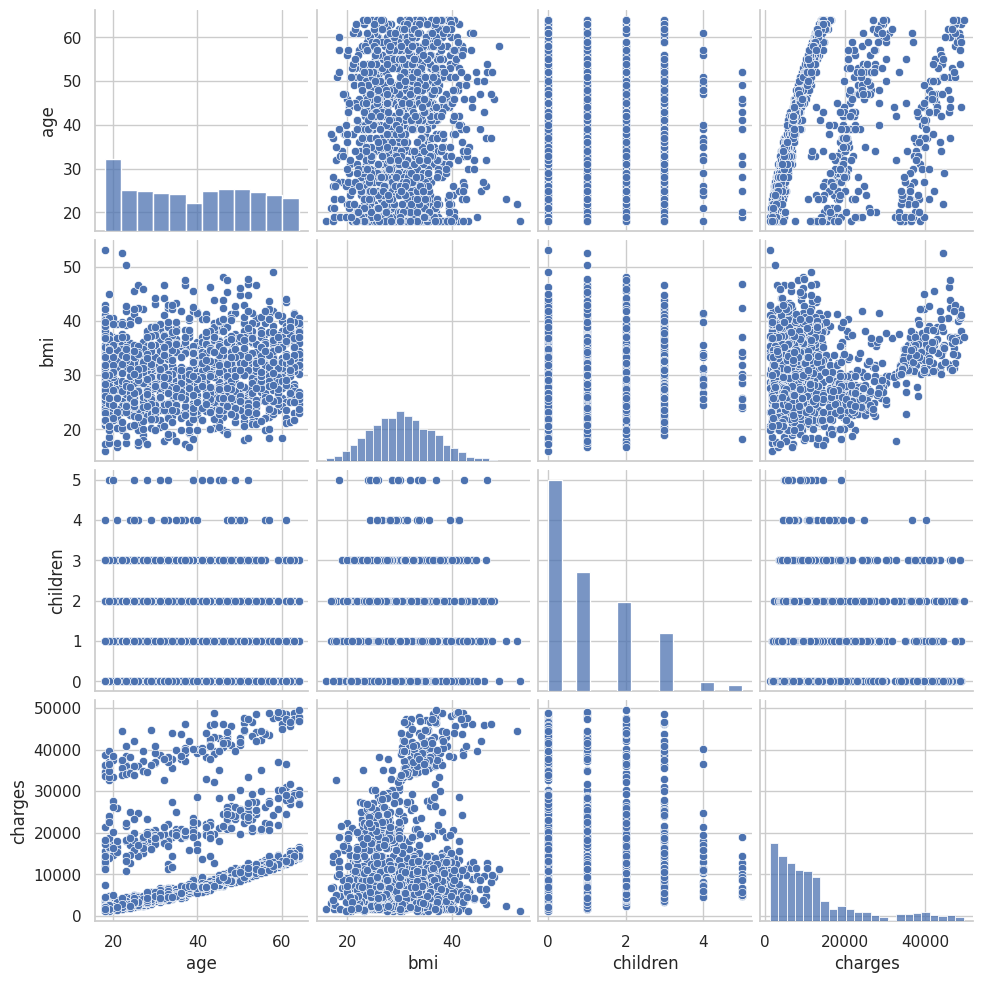

In [102]:
sns.pairplot(df, height = 2.5)
plt.show()

#imc distribucion normal.
# se ven en algunos graifcos casos como 3 categorias, interesante para el analisis

Puntos interesantes a ver:

- Hay 3 grupos de personas diferentes que se clasifican en edad / cargos, esto puede ser un punto a analizar después.

En general los valores se distribuyen de manera esperada. Con valores extremos en el caso de los cargos, sin embargo esto es de esperarse pues los cargos en los hospitales pueden variar mucho por quedarse un día más en el hospital o incluso por procedimientos extras.

- Parece que los datos están limpios, la variable de índice de masa corporal se distribuye de manera normal o gausiana, lo cual sería esperado en un índice de este tipo.

<Axes: >

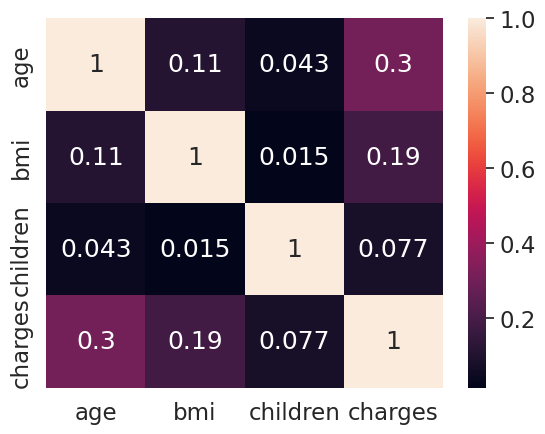

In [103]:
import numpy as np

#****Heatmap, en numéricas

#sacamos correlaciones
cm = np.corrcoef(df[cols_numericas].values.T)

sns.set(font_scale=1.5)
sns.heatmap(cm, annot = True, yticklabels=cols_numericas, xticklabels=cols_numericas)

## Utilizando las demás variables
Las demás variables son variables categoricas, sexo, fumador, región. Para poder utilizarlas utilizaremos la función get_dummies de pandas. 

Ahora la verás en acción

In [104]:
df = pd.get_dummies(df, columns = cols_categoricas, drop_first = True)
df.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Creando modelos 
Primero se usará un modelo con todas las variables.

In [105]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [106]:
#ssplit x,y, descriptores vs target
x_cols = df.drop(['charges'], axis =1, inplace= False)
list(x_cols)

['age',
 'bmi',
 'children',
 'sex_male',
 'smoker_yes',
 'region_northwest',
 'region_southeast',
 'region_southwest']

In [107]:
y_col = df[['charges']]

In [108]:
#hago numpy array con estas columnas, es util hacer arrays envez de DF's, no se porque, da igual la verdad
X = df[list(x_cols)].values
y = y_col.values

In [109]:
#split train y test
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [110]:
#Scaler, creo el objeto sobre todos los datos
sc_x = StandardScaler().fit(X)
sc_y = StandardScaler().fit(y)

In [111]:
#normalizo cada cosa
x_train = sc_x.transform(X_train);
x_test = sc_x.transform(X_test);

In [112]:
y_train = sc_y.transform(y_train)
y_test = sc_y.transform(y_test)

MODELO

In [113]:
#creo modelo
model = LinearRegression()

In [114]:
#entreno con train
model.fit(X_train, y_train)

LinearRegression()

In [115]:
#predigo a test
y_pred = model.predict(X_test)

Revisando lo predicho

In [116]:
# 333 instancias, 1 target
y_pred.shape

(333, 1)

## Funciones de métricas
El siguiente punto es calcular las métricas del modelo.

In [117]:
import sklearn.metrics as metrics

In [118]:
#mean square error
mse = metrics.mean_squared_error(y_test, y_pred)

#r2
r2 = metrics.r2_score(y_test, y_pred)

In [119]:
print("r2: \t", r2.round(4))
print("mse: \t", r2.round(4))

r2: 	 0.7865
mse: 	 0.7865


El siguiente código muestra un resumen general de los resultados.

In [120]:
from regressors import stats

Tomo intercepto y coeficientes

In [121]:
model.intercept_ = model.intercept_[0]
model.coef_ = model.coef_.reshape(-1)

Stats summary

In [122]:
y_test = y_test.reshape(-1)

print("==========Summary==========")
# le paso modelo, datos de test y columnas se las doy de lo que ya cree
stats.summary(model, X_test, y_test, list(x_cols))

==========Summary==========
Residuals:
    Min     1Q  Median     3Q    Max
-2.0373 -0.127  0.0928 0.2414 0.7901


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept       -2.116530    0.158222 -13.3770  0.000000
age               0.022238    0.001362  16.3222  0.000000
bmi               0.028476    0.002170  13.1200  0.000000
children          0.043807    0.022989   1.9055  0.057572
sex_male         -0.019528    0.054061  -0.3612  0.718160
smoker_yes        1.928229    0.068263  28.2470  0.000000
region_northwest -0.057794    0.069753  -0.8286  0.407949
region_southeast -0.085473    0.072588  -1.1775  0.239831
region_southwest -0.086156    0.070589  -1.2205  0.223127
---
R-squared:  0.78646,    Adjusted R-squared:  0.78118
F-statistic: 149.16 on 8 features


Finalmente tenemos la función que calcula los residuales. Es importante notar que es una simple resta entre los valores reales y los predichos.

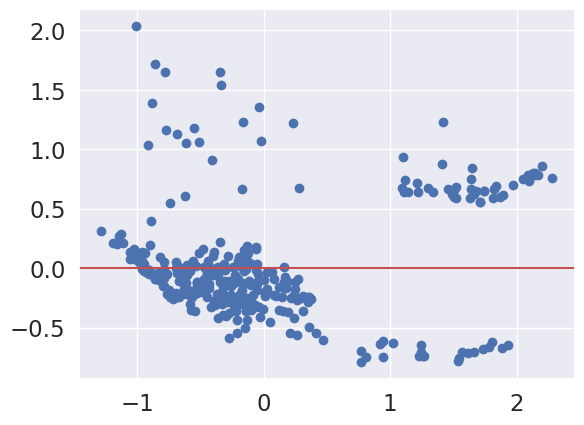

In [124]:
residuals = np.subtract(y_test, y_pred.reshape(-1))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


## Segundo modelo
Estos resultados de arriba son buenos, pero se pueden mejorar. Intentaremos hacer algunas transformaciones sobre las variables que pueden ser de utilidad.

Analizando el segundo modelo